<a href="https://colab.research.google.com/github/LarsGart/NLP-Social-Media-Mining-for-Health-Monitoring/blob/experimental/Exploratory_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import demoji
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [40]:
df = pd.read_csv(r'drive/MyDrive/Colab Notebooks/NLP-Social-Media-Mining-for-Health-Monitoring/datasets/Task 1/task2_en_training.tsv', sep = '\t')
df_eval = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/NLP-Social-Media-Mining-for-Health-Monitoring/datasets/Task 1/task2_en_validation.tsv', sep = '\t')
df_eval

,tweet_id,user_id,class,tweet
0,343909778008973312,464336224,0,i don't fucking need humira
1,352823276889837570,590337731,0,"my retake is next friday, if i bloody fail aga..."
2,339867818843594756,246979971,0,"@doctorchristian scared to start fluoxetine, w..."
3,349294537367236611,149749939,0,"@intuitivegal1 ok, if you stopped taking the l..."
4,354256195432882177,54516759,0,novartis announces secukinumab (ain457) demons...
...,...,...,...,...
5129,350859685227798531,1460971,1,@crohns_twins that sucks. humira made me so si...
5130,332156923002617859,1403896746,1,i've had no appetite since i started on prozac...
5131,347529563628253184,15910137,1,takin anbien &amp;seroquel for bad insomnia gi...
5132,331500382746472448,246440597,1,note to self - nicotine lozenge &amp; alcohol ...


### Average Number of Tweets per User

In [7]:
sum(list(dict(df['user_id'].value_counts()).values())) / len(list(dict(df['user_id'].value_counts()).values()))

1.2693234476367006

### Added this code to clean the text<br>
need to change text in the dataset<br>

In [8]:
def clean_tweet(tweet):
    tweet = re.sub(r"#", "", tweet, 0, re.MULTILINE)
    tweet = re.sub(r"rt: ", "", tweet, 0, re.MULTILINE)
    tweet = tweet.lower()
    regex_mentions = r"@\w+"
    tweet = re.sub(regex_mentions, "", tweet, 0, re.MULTILINE)
#     regex_hash = r"(#[^\s]+)"
#     tweet = re.sub(regex_hash, "", tweet, 0, re.MULTILINE)
#     hash_matched = re.finditer(
#         regex_hash, tweet['full_text'], re.MULTILINE)
    url_regex = r"(http[^\s]+)"
    tweet = re.sub(url_regex, "", tweet, 0, re.MULTILINE)
#     special_char_re = r"[^(?u)\w]+"
#     tweet = re.sub(special_char_re, " ", tweet, 0, re.MULTILINE)
    return tweet

In [9]:
def remove_emojis(text):
    emoticons_happy = list([
        ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
        ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
        '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
        'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
        '<3'
    ])
    emoticons_sad = list([
        ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
        ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
        ':c', ':{', '>:\\', ';('
    ])
    all_emoticons = emoticons_happy + emoticons_sad

    emojis = list(demoji.findall(text).keys())
    clean_text = demoji.replace(text, '')

    for emo in all_emoticons:
        if (emo in clean_text):
            clean_text = clean_text.replace(emo, '')
            emojis.append(emo)

    clean_text = clean_text.replace('\n', '', -1)
    
    # using regex to remove urls
    # regex_url = r"https:(.*)[A-Za-z0-9]"
    # clean_text = re.sub(regex_url, '', clean_text, 0, re.MULTILINE)

    return clean_text #, emojis

In [42]:
df['tweet'] = df['tweet'].map(lambda tweet: clean_tweet(remove_emojis(tweet)))
df_eval['tweet'] = df_eval['tweet'].map(lambda tweet: clean_tweet(remove_emojis(tweet)))

### Highly Imbalanced Dataset<br>
We will have to address this.<br>
We can explore creating synthetic data, using TOMEK-Links, etc.

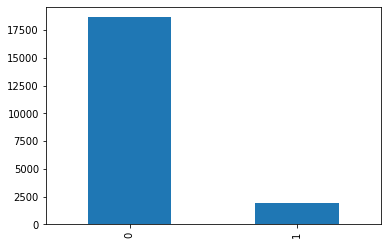

In [43]:
df['class'].value_counts().plot(kind='bar')

### Addressing Duplicate Tweets<br>
We must remove duplicate rows to avoid redundancy and model overfitting

In [44]:
len(df.index) - df['tweet'].nunique()

432

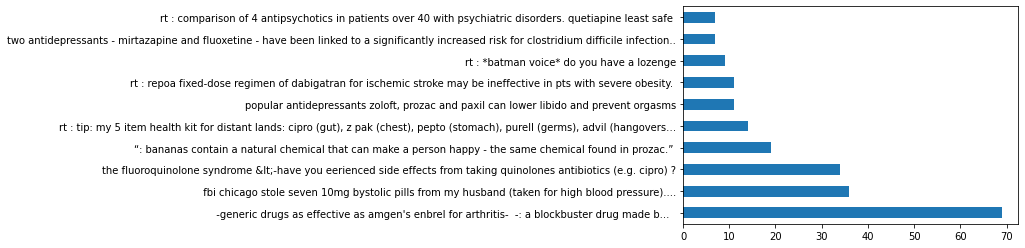

In [45]:
df['tweet'].value_counts()[:10].plot(kind='barh')

### Tweets belonging to class 1 are 8.9 characters longer on average

In [46]:
df[df['class'] == 0]['tweet'].apply(len).mean()

89.39670618529048

In [47]:
df[df['class'] == 1]['tweet'].apply(len).mean()

99.32107199159222

In [48]:
df_0 = df[df['class'] == 0]
df_0.shape

(18641, 4)

In [49]:
df_1 = df[df['class'] == 1]
df_1.shape

(1903, 4)

In [50]:
df_0_downsampled = df_0.sample(df_1.shape[0])
df_0_downsampled.shape

(1903, 4)

In [51]:
df_balanced = pd.concat([df_1,df_0_downsampled])
df_balanced.shape

(3806, 4)

In [52]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
X_train, X_test, y_train, y_test = df_balanced['tweet'], df_eval['tweet'], df_balanced['class'], df_eval['class']

In [53]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [54]:
#BERT Layers
text_input = tf.keras.layers.Input(shape = (), dtype=tf.string , name="tweet")
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

#NN Layers
l=tf.keras.layers.Dropout(0.1, name = "dropout")(outputs["pooled_output"])
l=tf.keras.layers.Dense(1,activation='sigmoid',name='output')(l)

#final Model
model = tf.keras.Model(inputs = [text_input] , outputs = [l])


In [55]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 tweet (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_mask': (Non  0           ['tweet[0][0]']                  
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [56]:
METRICS =[
          tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer="adam",
              loss = "binary_crossentropy",
              metrics = METRICS)

In [57]:
model.fit(X_train,y_train,epochs=10)

Epoch 1/10
119/119 [==============================] - 47s 319ms/step - loss: 0.6902 - accuracy: 0.5607 - precision: 0.5590 - recall: 0.5754
Epoch 2/10
119/119 [==============================] - 39s 325ms/step - loss: 0.6507 - accuracy: 0.6209 - precision: 0.6198 - recall: 0.6253
Epoch 3/10
119/119 [==============================] - 39s 330ms/step - loss: 0.6292 - accuracy: 0.6437 - precision: 0.6396 - recall: 0.6584
Epoch 4/10
119/119 [==============================] - 40s 332ms/step - loss: 0.6164 - accuracy: 0.6603 - precision: 0.6527 - recall: 0.6852
Epoch 5/10
119/119 [==============================] - 40s 335ms/step - loss: 0.6080 - accuracy: 0.6750 - precision: 0.6662 - recall: 0.7015
Epoch 6/10
119/119 [==============================] - 40s 337ms/step - loss: 0.6012 - accuracy: 0.6734 - precision: 0.6675 - recall: 0.6910
Epoch 7/10
119/119 [==============================] - 40s 340ms/step - loss: 0.5974 - accuracy: 0.6831 - precision: 0.6757 - recall: 0.7042
Epoch 8/10
119/119 [

In [58]:
model.evaluate(X_test,y_test)

161/161 [==============================] - 54s 328ms/step - loss: 0.6069 - accuracy: 0.6607 - precision: 0.1769 - recall: 0.7321


[0.6068854331970215,
 0.6606934070587158,
 0.17686034739017487,
 0.7320675253868103]

In [59]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [60]:
y_predicted = np.where(y_predicted > 0.5,1,0)
y_predicted

array([1, 0, 0, ..., 1, 0, 0])

In [61]:
from sklearn.metrics import confusion_matrix,classification_report

cm = confusion_matrix(y_test,y_predicted)
cm

array([[3045, 1615],
       [ 127,  347]])

Text(33.0, 0.5, 'Truth')

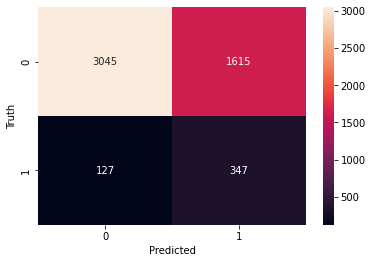

In [62]:
from matplotlib import pyplot as plt
import seaborn as sn

sn.heatmap(cm, annot = True , fmt = 'd')
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [63]:
print(classification_report(y_test,y_predicted))

              precision    recall  f1-score   support

           0       0.96      0.65      0.78      4660
           1       0.18      0.73      0.28       474

    accuracy                           0.66      5134
   macro avg       0.57      0.69      0.53      5134
weighted avg       0.89      0.66      0.73      5134

